In [1]:
import pdr
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval

import warnings
warnings.filterwarnings('ignore')

In [ ]:
movie_fd = pdr.read('test_data/e23456/e23456-nd-f0120-b00-movie-r.fits')
movie_nd = pdr.read('test_data/e23456/e23456-nd-f0120-b00-movie-r.fits')
movie_fd.load_all()
movie_nd.load_all()

In [3]:
# Although it doesn't change the data visualization in this case, let's
# give an example of how to extract and scale exposure time for movies.
nframes_fd = movie_fd['COUNT_HEADER']['NAXIS3']
nframes_nd = movie_nd['COUNT_HEADER']['NAXIS3']
assert nframes_fd == nframes_nd
nframes = nframes_fd

# The effective exposure times are stored in the `EXPT_N` keywords where N is the frame index.
expt_fd = [movie_fd['COUNT_HEADER'][f'EXPT_{i}'] for i in range(nframes_fd)]
expt_nd = [movie_nd['COUNT_HEADER'][f'EXPT_{i}'] for i in range(nframes_nd)]
print(f'FUV effective exposure times: {expt_fd}')
print(f'NUV effective exposure times: {expt_nd}')

FUV effective exposure times: [103.74, 105.746, 105.919, 106.049, 102.603, 106.205, 106.241, 106.246, 106.235, 106.206, 106.137, 106.084, 105.953, 105.753, 21.112]
NUV effective exposure times: [103.74, 105.746, 105.919, 106.049, 102.603, 106.205, 106.241, 106.246, 106.235, 106.206, 106.137, 106.084, 105.953, 105.753, 21.112]


In [4]:
from IPython.display import Image, display
import imageio

masked_frames = []
cmap = plt.get_cmap("binary_r").copy()
cmap.set_bad(color='yellow')  # Masked pixels will appear red

for i in range(nframes):
    COUNT_fd_masked = np.ma.masked_where(movie_fd['FLAG'][i] != 0, movie_fd['COUNT'][i], copy=True)
    COUNT_nd_masked = np.ma.masked_where(movie_nd['FLAG'][i] != 0, movie_nd['COUNT'][i], copy=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(ZScaleInterval()(COUNT_fd_masked)/expt_fd[i], cmap=cmap, origin="lower")
    axes[0].set_title(f'FUV Frame {i}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(ZScaleInterval()(COUNT_nd_masked)/expt_nd[i], cmap=cmap, origin="lower")
    axes[1].set_title(f'NUV Frame {i}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.tight_layout()
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]
    masked_frames.append(frame)
    plt.close(fig)

imageio.mimsave('movie.gif', masked_frames, duration=0.5, loop=0)

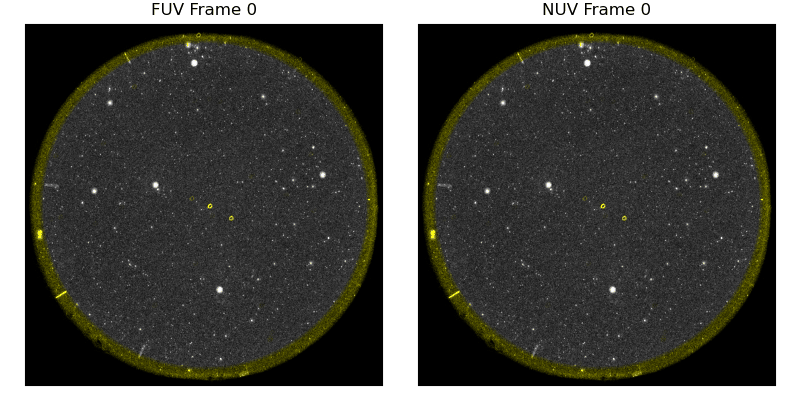

In [5]:
from IPython.display import Image

display(Image(filename='movie.gif'))

In [6]:
movie_data = movie_nd['COUNT']
exptimes = expt_nd
normalized_data = np.array([movie_data[i] / exptimes[i] for i in range(len(exptimes))])
np.shape(normalized_data)

(15, 3099, 3065)

In [10]:
# Calculate frame-to-frame differences to identify changing regions
frame_diffs = np.diff(normalized_data, axis=0)  # Shape: (14, 3099, 3065)

# Calculate statistics for each pixel across all frame differences
pixel_std = np.std(frame_diffs, axis=0)  # Standard deviation for each pixel
pixel_mean = np.mean(frame_diffs, axis=0)  # Mean difference for each pixel
pixel_max_change = np.max(np.abs(frame_diffs), axis=0)  # Maximum absolute change

# MUCH MORE SENSITIVE DETECTION METHODS
# Method 1: Very low percentile threshold for standard deviation (top 50% most variable)
std_threshold = np.percentile(pixel_std[pixel_std > 0], 50)  # Much more sensitive
variability_mask_std = pixel_std > std_threshold

# Method 2: Low threshold for maximum change (top 30% of changes)
max_change_threshold = np.percentile(pixel_max_change[pixel_max_change > 0], 70)
variability_mask_max = pixel_max_change > max_change_threshold

# Method 3: Very sensitive Z-score detection (1.5 sigma instead of 3)
z_scores = np.abs(frame_diffs - pixel_mean[None, :, :]) / (pixel_std[None, :, :] + 1e-10)
significant_changes = np.any(z_scores > 1.5, axis=0)  # Much more sensitive threshold

# Method 4: Coefficient of variation (CV) - sensitive to relative changes
pixel_cv = pixel_std / (np.abs(pixel_mean) + 1e-10)  # Coefficient of variation
cv_threshold = np.percentile(pixel_cv[np.isfinite(pixel_cv)], 80)
variability_mask_cv = pixel_cv > cv_threshold

# Method 5: Range-based detection (difference between max and min across frames)
pixel_range = np.ptp(normalized_data, axis=0)  # Peak-to-peak range
range_threshold = np.percentile(pixel_range[pixel_range > 0], 75)
variability_mask_range = pixel_range > range_threshold

# Method 6: Very sensitive - any pixel that changes more than 2% of its mean value
relative_changes = np.abs(frame_diffs) / (np.abs(pixel_mean[None, :, :]) + 1e-10)
variability_mask_relative = np.any(relative_changes > 0.02, axis=0)  # 2% change threshold

# Combine all masks - regions that are variable by any method
combined_mask = (variability_mask_std | variability_mask_max | significant_changes | 
                variability_mask_cv | variability_mask_range | variability_mask_relative)

print(f"Pixels identified as variable (SENSITIVE DETECTION):")
print(f"  Standard deviation method: {np.sum(variability_mask_std)} pixels ({100*np.sum(variability_mask_std)/variability_mask_std.size:.1f}%)")
print(f"  Maximum change method: {np.sum(variability_mask_max)} pixels ({100*np.sum(variability_mask_max)/variability_mask_max.size:.1f}%)")
print(f"  Z-score method (1.5σ): {np.sum(significant_changes)} pixels ({100*np.sum(significant_changes)/significant_changes.size:.1f}%)")
print(f"  Coefficient of variation: {np.sum(variability_mask_cv)} pixels ({100*np.sum(variability_mask_cv)/variability_mask_cv.size:.1f}%)")
print(f"  Range method: {np.sum(variability_mask_range)} pixels ({100*np.sum(variability_mask_range)/variability_mask_range.size:.1f}%)")
print(f"  Relative change (2%): {np.sum(variability_mask_relative)} pixels ({100*np.sum(variability_mask_relative)/variability_mask_relative.size:.1f}%)")
print(f"  COMBINED SENSITIVE MASK: {np.sum(combined_mask)} pixels ({100*np.sum(combined_mask)/combined_mask.size:.1f}%)")

Pixels identified as variable (SENSITIVE DETECTION):
  Standard deviation method: 3484497 pixels (36.7%)
  Maximum change method: 2090980 pixels (22.0%)
  Z-score method (1.5σ): 6494591 pixels (68.4%)
  Coefficient of variation: 1899475 pixels (20.0%)
  Range method: 1742514 pixels (18.3%)
  Relative change (2%): 6968996 pixels (73.4%)
  COMBINED SENSITIVE MASK: 6970055 pixels (73.4%)


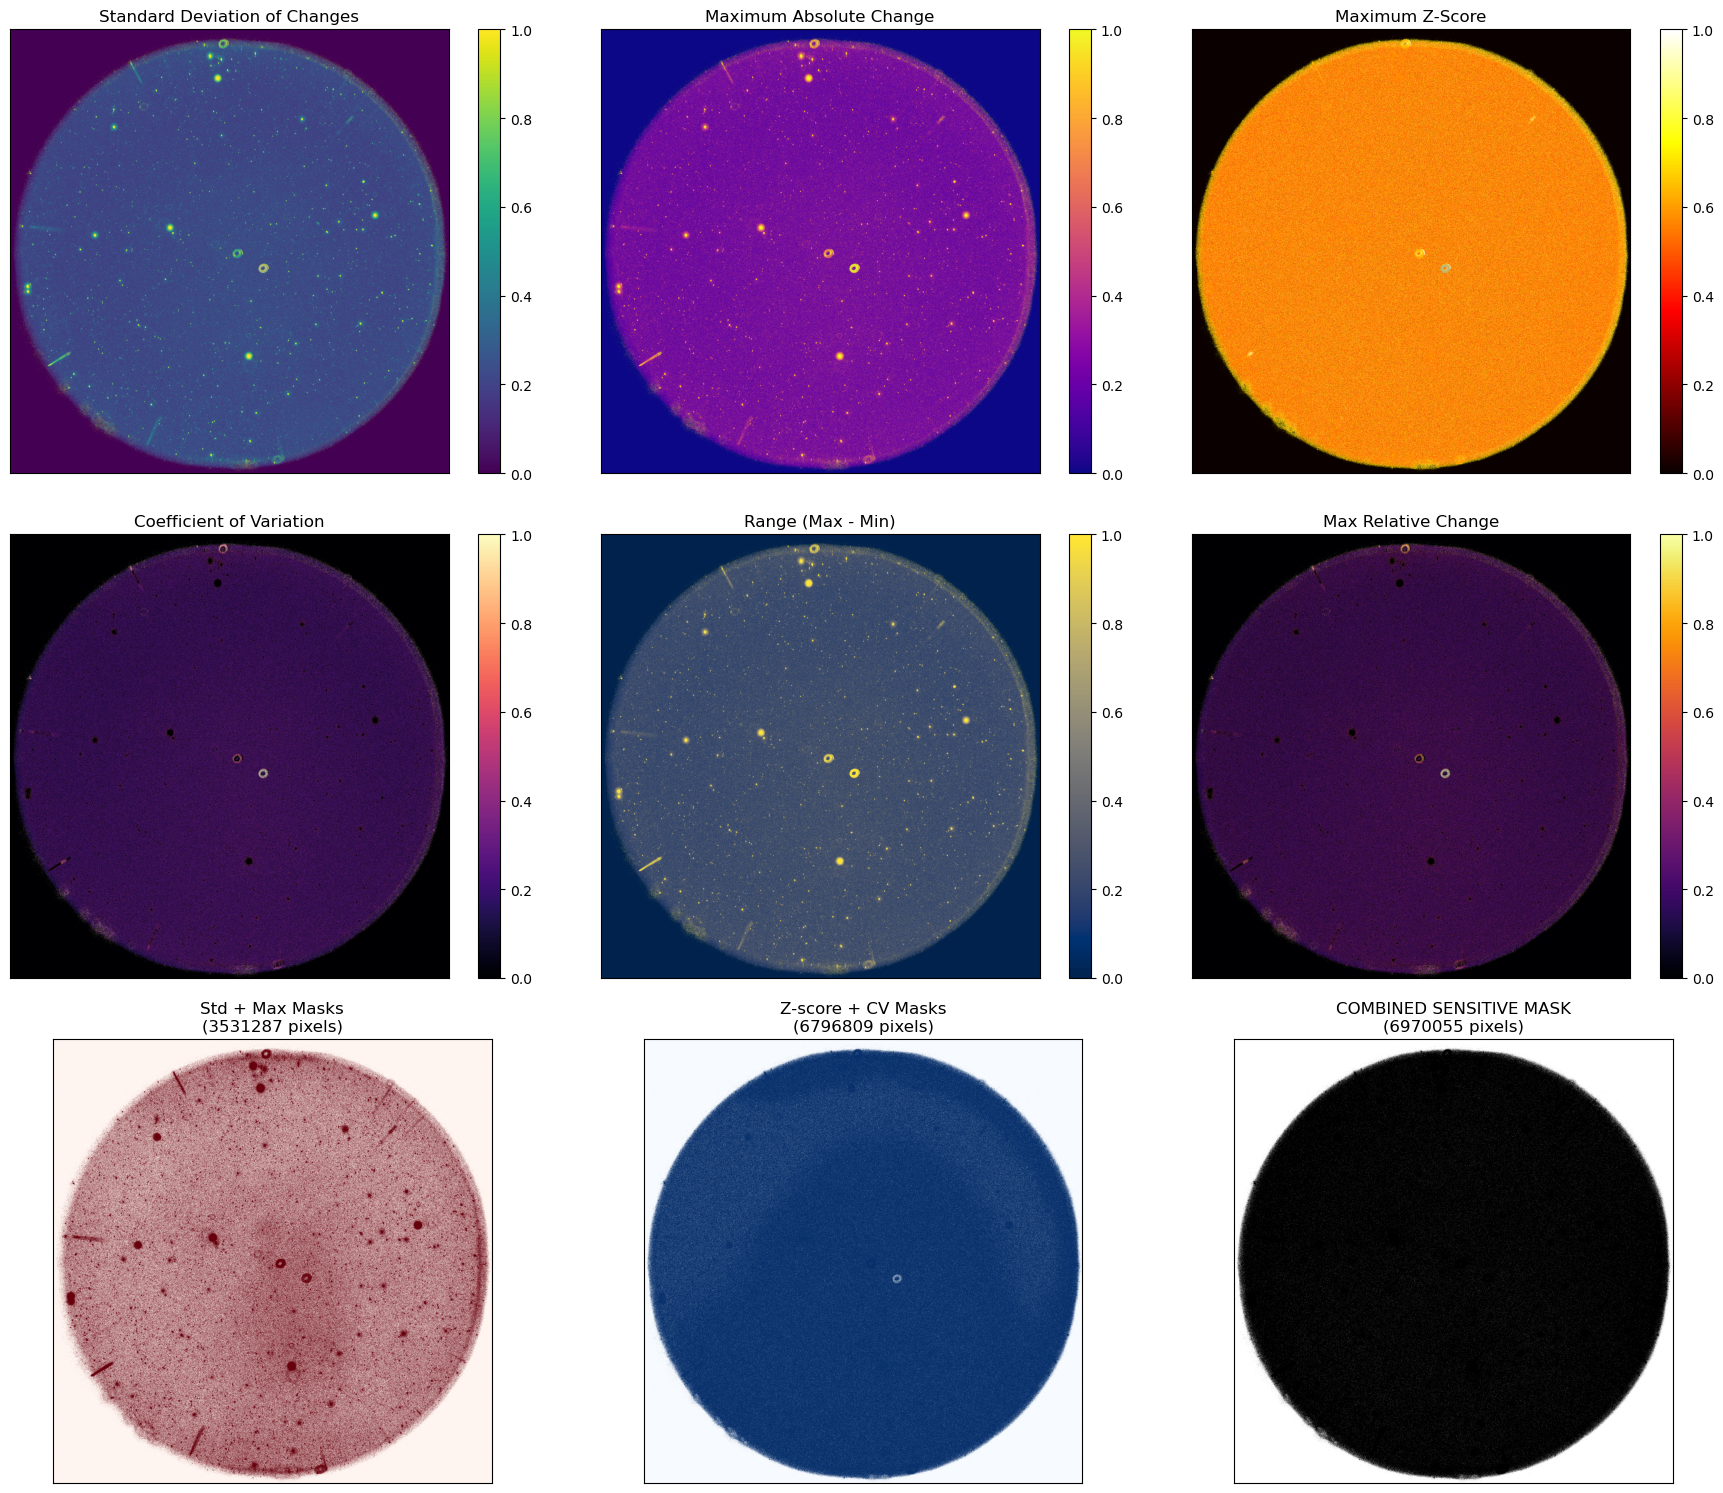

In [11]:
# Visualize the sensitive variability analysis
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Top row: variability metrics
im1 = axes[0,0].imshow(ZScaleInterval()(pixel_std), cmap='viridis', origin='lower')
axes[0,0].set_title('Standard Deviation of Changes')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
plt.colorbar(im1, ax=axes[0,0])

im2 = axes[0,1].imshow(ZScaleInterval()(pixel_max_change), cmap='plasma', origin='lower')
axes[0,1].set_title('Maximum Absolute Change')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
plt.colorbar(im2, ax=axes[0,1])

im3 = axes[0,2].imshow(ZScaleInterval()(np.max(z_scores, axis=0)), cmap='hot', origin='lower')
axes[0,2].set_title('Maximum Z-Score')
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])
plt.colorbar(im3, ax=axes[0,2])

# Middle row: additional metrics
im4 = axes[1,0].imshow(ZScaleInterval()(pixel_cv), cmap='magma', origin='lower')
axes[1,0].set_title('Coefficient of Variation')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
plt.colorbar(im4, ax=axes[1,0])

im5 = axes[1,1].imshow(ZScaleInterval()(pixel_range), cmap='cividis', origin='lower')
axes[1,1].set_title('Range (Max - Min)')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
plt.colorbar(im5, ax=axes[1,1])

im6 = axes[1,2].imshow(ZScaleInterval()(np.max(relative_changes, axis=0)), cmap='inferno', origin='lower')
axes[1,2].set_title('Max Relative Change')
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])
plt.colorbar(im6, ax=axes[1,2])

# Bottom row: masks
axes[2,0].imshow(variability_mask_std | variability_mask_max, cmap='Reds', origin='lower')
axes[2,0].set_title(f'Std + Max Masks\n({np.sum(variability_mask_std | variability_mask_max)} pixels)')
axes[2,0].set_xticks([])
axes[2,0].set_yticks([])

axes[2,1].imshow(significant_changes | variability_mask_cv, cmap='Blues', origin='lower')
axes[2,1].set_title(f'Z-score + CV Masks\n({np.sum(significant_changes | variability_mask_cv)} pixels)')
axes[2,1].set_xticks([])
axes[2,1].set_yticks([])

axes[2,2].imshow(combined_mask, cmap='Greys', origin='lower')
axes[2,2].set_title(f'COMBINED SENSITIVE MASK\n({np.sum(combined_mask)} pixels)')
axes[2,2].set_xticks([])
axes[2,2].set_yticks([])

plt.tight_layout()
plt.show()

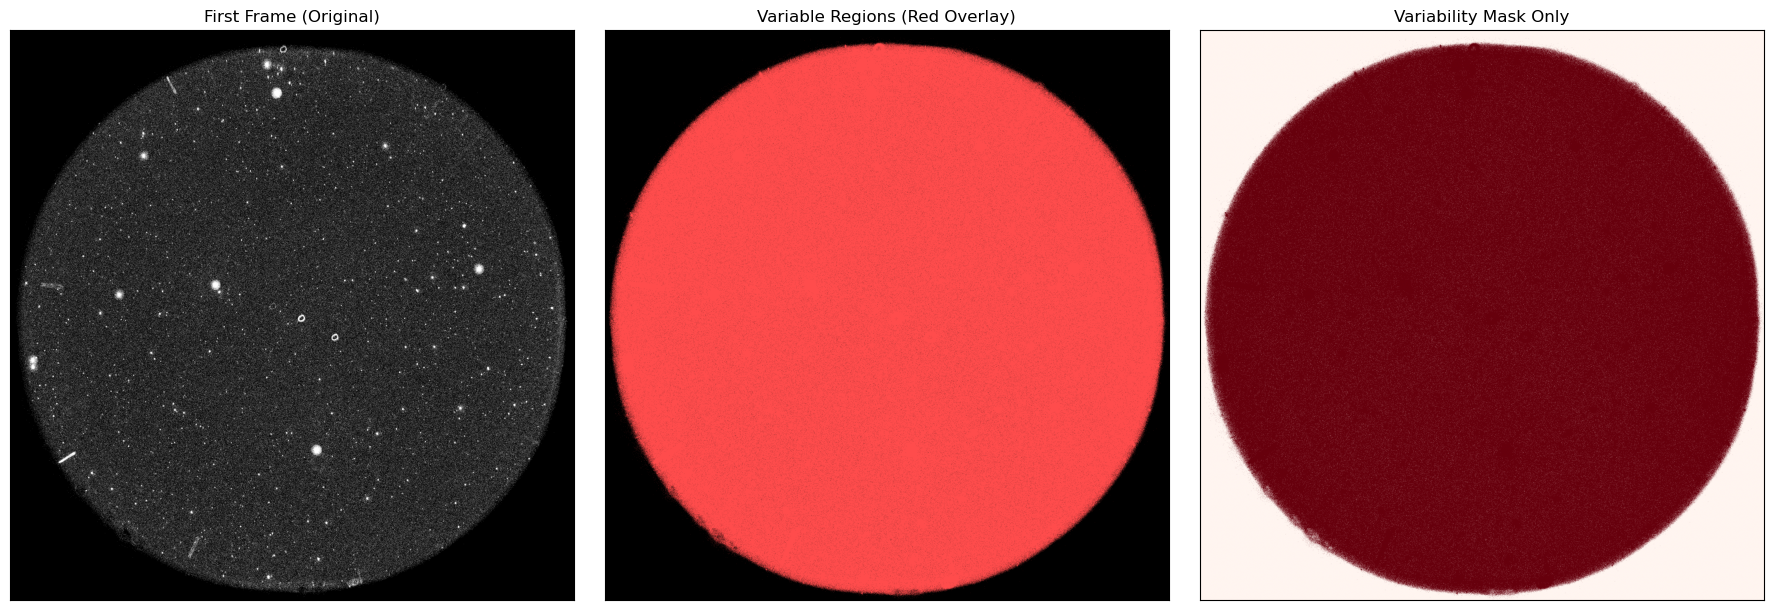

In [12]:
# Show the variability mask overlaid on the first frame
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original first frame
axes[0].imshow(ZScaleInterval()(normalized_data[0]), cmap='binary_r', origin='lower')
axes[0].set_title('First Frame (Original)')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Overlay variability mask on first frame
overlay = normalized_data[0].copy()
overlay_rgb = np.stack([overlay, overlay, overlay], axis=-1)
overlay_rgb = ZScaleInterval()(overlay_rgb)

# Highlight variable regions in red
overlay_rgb[combined_mask, 0] = 1.0  # Red channel
overlay_rgb[combined_mask, 1] = 0.3  # Reduce green
overlay_rgb[combined_mask, 2] = 0.3  # Reduce blue

axes[1].imshow(overlay_rgb, origin='lower')
axes[1].set_title('Variable Regions (Red Overlay)')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Just the mask
axes[2].imshow(combined_mask, cmap='Reds', origin='lower')
axes[2].set_title('Variability Mask Only')
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show()